In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

# Verifique se CUDA está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
# Preprocessamento do MNIST
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Alguns hiperparâmetros
input_dim = 784  # Imagens 28x28 serão representadas por um array de 784 entradas
label_dim = 10  # Número de labels possíveis (de 0 a 9)

hidden_dim_encoder = 784
hidden_dim_decoder = 64   # Diminuímos a dimensão dos dados no decoder
# caso queiramos que o encoder "capture" mais features, seria interessante aumentar seu hidden_dim
# o mesmo vale para o decoder, onde poderiamos buscar "gerar" mais complexidade ao modelo
latent_dim = 10  # dimensão de representação latente

100%|██████████| 26421880/26421880 [00:04<00:00, 6469820.32it/s] 


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 189312.26it/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2744422.29it/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 5094921.42it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [79]:
import numpy as np

In [203]:
class CVAE(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim_encoder, hidden_dim_decoder, latent_dim):
        super(CVAE, self).__init__()

        # Encoder
        hid_channels = 16
        kernel_size = 4

        self.conv1 = nn.Conv2d(1, hid_channels, kernel_size, stride=2, padding=1)
        self.conv2 = nn.Conv2d(hid_channels, hid_channels * 2, kernel_size, stride=2, padding=1)
        self.fc1 = nn.Linear(hid_channels * 2 * 7 * 7 + label_dim, hidden_dim_encoder)
        self.fc_mean = nn.Linear(hidden_dim_encoder, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim_encoder, latent_dim)
        
        # Decoder
        self.img_size = 28*28
        hidden_dim_decoder = 256
        self.reshape = (hid_channels, 7, 7)  # adjusted to reflect smaller image size

        self.lin1 = nn.Linear(latent_dim + label_dim, hidden_dim_decoder)
        self.lin2 = nn.Linear(hidden_dim_decoder, hidden_dim_decoder)
        self.lin3 = nn.Linear(hidden_dim_decoder, np.product(self.reshape))

        cnn_kwargs = dict(stride=2, padding=1)
        self.convT1 = nn.ConvTranspose2d(hid_channels, hid_channels, kernel_size, **cnn_kwargs)
        self.convT2 = nn.ConvTranspose2d(hid_channels, 1, kernel_size, **cnn_kwargs)

    def encode(self, x, y):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        input = torch.cat((x, y), dim=1) 
        hidden = F.relu(self.fc1(input))
        mean = self.fc_mean(hidden)
        logvar = self.fc_logvar(hidden)
        return mean, logvar

    def reparametrize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        z = mean + epsilon * std
        return z

    def decode(self, z, y):
        batch_size = z.size(0)
        input = torch.cat((z, y), dim=1)

        # Fully connected layers with ReLu activations
        x = F.relu(self.lin1(input))
        x = F.relu(self.lin2(x))
        x = F.relu(self.lin3(x))
        x = x.view(batch_size, *self.reshape)

        # Convolutional layers with ReLu activations
        x = F.relu(self.convT1(x))

        # Sigmoid activation for final conv layer
        x = torch.sigmoid(self.convT2(x))
        return x

    def forward(self, x, y):
        mean, logvar = self.encode(x, y)
        z = self.reparametrize(mean, logvar)
        reconstructed = self.decode(z, y)
        return reconstructed, mean, logvar

def loss_function(reconstructed, x, mean, logvar, beta=0.5):
    # loss (binary cross-entropy)
    reconstruction_loss = F.binary_cross_entropy(reconstructed.view(-1, input_dim), x.view(-1, input_dim), reduction='sum')
    
    # loss (KL divergence)
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    
    total_loss = reconstruction_loss + beta * kl_loss
    return total_loss

model = CVAE(input_dim, label_dim, hidden_dim_encoder, hidden_dim_decoder, latent_dim)
model = model.to(device)

# podemos mudar o otimizador também / adicionamos weight_decay para implementar regularização L2
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-2)

C:\Users\atoma\AppData\Local\Temp\ipykernel_20308\831954225.py:77: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  model = CVAE(input_dim, label_dim, hidden_dim_encoder, hidden_dim_decoder, latent_dim)


In [204]:
def train(model, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        train_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = F.one_hot(labels, num_classes=10).type(torch.float).to(device)
            optimizer.zero_grad()
            
            reconstructed, mean, logvar = model(data, labels)
            
            loss = loss_function(reconstructed, data.view(-1, input_dim), mean, logvar)
            
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            
            # Print training information
            if batch_idx % 100 == 0:
                print('Epoch [{}/{}], Batch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, batch_idx+1, len(train_loader), loss.item()))
        
        print('Epoch [{}/{}], Average Loss: {:.4f}'
              .format(epoch+1, num_epochs, train_loss/len(train_loader)))

num_epochs = 10
train(model, optimizer, num_epochs)

Epoch [1/10], Batch [1/469], Loss: 73364.0000
Epoch [1/10], Batch [101/469], Loss: 40500.8828
Epoch [1/10], Batch [201/469], Loss: 35609.4180
Epoch [1/10], Batch [301/469], Loss: 32124.9590
Epoch [1/10], Batch [401/469], Loss: 32724.8730
Epoch [1/10], Average Loss: 37659.3652
Epoch [2/10], Batch [1/469], Loss: 33692.4922
Epoch [2/10], Batch [101/469], Loss: 31830.0156
Epoch [2/10], Batch [201/469], Loss: 31807.4707
Epoch [2/10], Batch [301/469], Loss: 31819.3066
Epoch [2/10], Batch [401/469], Loss: 30838.7480
Epoch [2/10], Average Loss: 31678.7762
Epoch [3/10], Batch [1/469], Loss: 31577.0957
Epoch [3/10], Batch [101/469], Loss: 30605.3652
Epoch [3/10], Batch [201/469], Loss: 30091.2070
Epoch [3/10], Batch [301/469], Loss: 31669.5352
Epoch [3/10], Batch [401/469], Loss: 30443.5254
Epoch [3/10], Average Loss: 30907.7212
Epoch [4/10], Batch [1/469], Loss: 30699.4355
Epoch [4/10], Batch [101/469], Loss: 29692.1816
Epoch [4/10], Batch [201/469], Loss: 30305.6934
Epoch [4/10], Batch [301/46

Imagens de: Sneaker


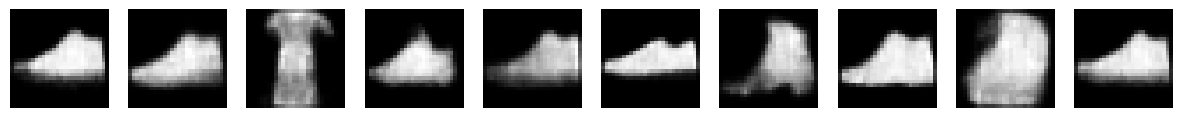

In [209]:

import matplotlib.pyplot as plt

# geraçao de novas amostras
def generate_samples(model, num_samples, label):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        y = torch.zeros(num_samples, label_dim).to(device)
        y[:, label] = 1
        generated_samples = model.decode(z, y)

    clothing_map = {
        0: 'T-shirt/top',
        1: 'Trouser',
        2: 'Pullover',
        3: 'Dress',
        4: 'Coat',
        5: 'Sandal',
        6: 'Shirt',
        7: 'Sneaker',
        8: 'Bag',
        9: 'Ankle boot'
    }
    
    print(f'Imagens de: {clothing_map[label]}')
    return generated_samples

num_samples = 10
generated_samples = generate_samples(model, num_samples, 7)

generated_samples = generated_samples.view(-1, 28, 28)

fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
for i in range(num_samples):
    axes[i].imshow(generated_samples[i].cpu().numpy(), cmap='gray')
    axes[i].axis('off')
plt.show()